# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. Get probe template
2. **Get the Bragg disks**
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 2: Get the Bragg disks

In this step the Bragg disks are located, as follows:

* For each diffraction pattern:
    * Cross correlate (or hybrid cross-phase correlate) the DP with the probe kernel
    * Get a first guess at Bragg disk positions by identifying positions and intensities of all local maxima
    * Filter out erroneous peaks by removing those too close together, in order of decreasing intensity
* Save Bragg disks list

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from time import time

from py4DSTEM.process.braggdiskdetection import find_Bragg_disks_selected, find_Bragg_disks, threshold_Braggpeaks
from py4DSTEM.file.datastructure import PointList, PointListArray
from py4DSTEM.file.readwrite import FileBrowser, read, append

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    deconvolution                       DiffractionSlice    
   2    deconvolution_1                     DiffractionSlice    
   3    probe_kernel                        DiffractionSlice    
   4    DF_image                            RealSlice           
   5    DF_image_1                          RealSlice           
   6    diffraction_shifts                  RealSlice           
   7    realslice_0                         RealSlice           
   8    strain_maps                         RealSlice           
   9    strain_maps_1                       RealSlice           
   10   uv_map                              RealSlice           
   11   uv_map_1                            RealSlice           
   12   lattice_vectors                     PointList           
   13   lattice_vectors_1                   PointList           
   14   Braggpeaks       

In [3]:
# Load data

dc = browser.get_dataobject('datacube')
probe_kernel = browser.get_dataobject('probe_kernel')
browser.close()

### Test parameters on a few diffraction patterns

Analyzed 3 diffraction patterns in 0h 0m 0s


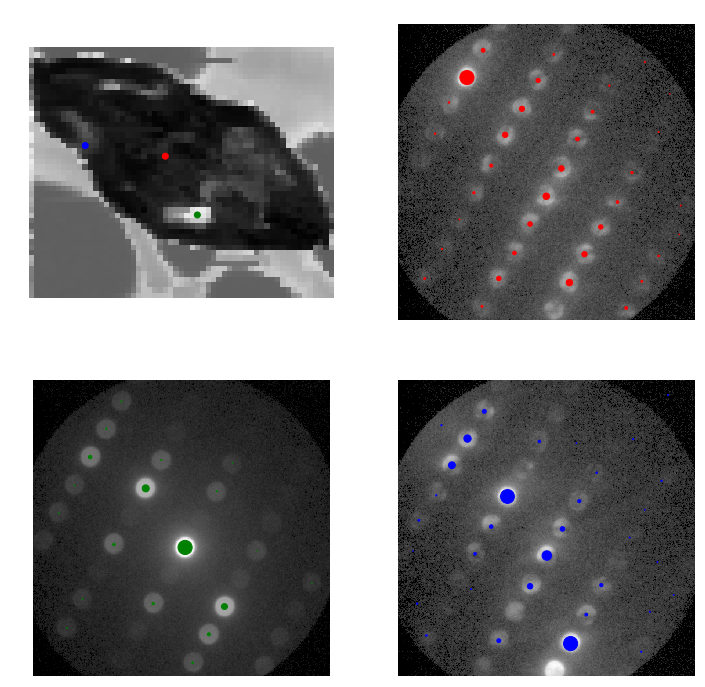

In [4]:
######## Parameters ########

# Select scan positions
Rxs=(20,31,18)
Rys=(25,31,10)

# Peak detection parameters
corrPower = 0.8
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 50
minRelativeIntensity = 0.001

# Display parameters
power=0.3
size_scale_factor = 200       # Set to zero to make all points the same size

############################

# Find peaks
peaks = find_Bragg_disks_selected(dc, probe_kernel.data2D, Rxs, Rys,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks)

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(dc.data4D[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data4D[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data4D[Rxs[2],Rys[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Find Bragg disks in all diffraction patterns

In [7]:
######## Parameters ########

corrPower = 0.8
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 50
minRelativeIntensity = 0.001
verbose = True

############################

Braggpeaks = find_Bragg_disks(dc, probe_kernel.data2D,
                         corrPower=corrPower,
                         sigma=sigma,
                         edgeBoundary=edgeBoundary,
                         minRelativeIntensity=minRelativeIntensity,
                         minPeakSpacing=minPeakSpacing,
                         maxNumPeaks=maxNumPeaks,
                         verbose=verbose)

Analyzing scan position 0, 0...
Analyzing scan position 0, 1...
Analyzing scan position 0, 2...
Analyzing scan position 0, 3...
Analyzing scan position 0, 4...
Analyzing scan position 0, 5...
Analyzing scan position 0, 6...
Analyzing scan position 0, 7...
Analyzing scan position 0, 8...
Analyzing scan position 0, 9...
Analyzing scan position 0, 10...
Analyzing scan position 0, 11...
Analyzing scan position 0, 12...
Analyzing scan position 0, 13...
Analyzing scan position 0, 14...
Analyzing scan position 0, 15...
Analyzing scan position 0, 16...
Analyzing scan position 0, 17...
Analyzing scan position 0, 18...
Analyzing scan position 0, 19...
Analyzing scan position 0, 20...
Analyzing scan position 0, 21...
Analyzing scan position 0, 22...
Analyzing scan position 0, 23...
Analyzing scan position 0, 24...
Analyzing scan position 0, 25...
Analyzing scan position 0, 26...
Analyzing scan position 0, 27...
Analyzing scan position 0, 28...
Analyzing scan position 0, 29...
Analyzing scan posit

Analyzing scan position 4, 22...
Analyzing scan position 4, 23...
Analyzing scan position 4, 24...
Analyzing scan position 4, 25...
Analyzing scan position 4, 26...
Analyzing scan position 4, 27...
Analyzing scan position 4, 28...
Analyzing scan position 4, 29...
Analyzing scan position 4, 30...
Analyzing scan position 4, 31...
Analyzing scan position 4, 32...
Analyzing scan position 4, 33...
Analyzing scan position 4, 34...
Analyzing scan position 4, 35...
Analyzing scan position 4, 36...
Analyzing scan position 4, 37...
Analyzing scan position 4, 38...
Analyzing scan position 4, 39...
Analyzing scan position 4, 40...
Analyzing scan position 4, 41...
Analyzing scan position 4, 42...
Analyzing scan position 4, 43...
Analyzing scan position 4, 44...
Analyzing scan position 4, 45...
Analyzing scan position 4, 46...
Analyzing scan position 4, 47...
Analyzing scan position 4, 48...
Analyzing scan position 4, 49...
Analyzing scan position 4, 50...
Analyzing scan position 4, 51...
Analyzing 

Analyzing scan position 8, 46...
Analyzing scan position 8, 47...
Analyzing scan position 8, 48...
Analyzing scan position 8, 49...
Analyzing scan position 8, 50...
Analyzing scan position 8, 51...
Analyzing scan position 8, 52...
Analyzing scan position 8, 53...
Analyzing scan position 8, 54...
Analyzing scan position 8, 55...
Analyzing scan position 8, 56...
Analyzing scan position 9, 0...
Analyzing scan position 9, 1...
Analyzing scan position 9, 2...
Analyzing scan position 9, 3...
Analyzing scan position 9, 4...
Analyzing scan position 9, 5...
Analyzing scan position 9, 6...
Analyzing scan position 9, 7...
Analyzing scan position 9, 8...
Analyzing scan position 9, 9...
Analyzing scan position 9, 10...
Analyzing scan position 9, 11...
Analyzing scan position 9, 12...
Analyzing scan position 9, 13...
Analyzing scan position 9, 14...
Analyzing scan position 9, 15...
Analyzing scan position 9, 16...
Analyzing scan position 9, 17...
Analyzing scan position 9, 18...
Analyzing scan posit

Analyzing scan position 13, 9...
Analyzing scan position 13, 10...
Analyzing scan position 13, 11...
Analyzing scan position 13, 12...
Analyzing scan position 13, 13...
Analyzing scan position 13, 14...
Analyzing scan position 13, 15...
Analyzing scan position 13, 16...
Analyzing scan position 13, 17...
Analyzing scan position 13, 18...
Analyzing scan position 13, 19...
Analyzing scan position 13, 20...
Analyzing scan position 13, 21...
Analyzing scan position 13, 22...
Analyzing scan position 13, 23...
Analyzing scan position 13, 24...
Analyzing scan position 13, 25...
Analyzing scan position 13, 26...
Analyzing scan position 13, 27...
Analyzing scan position 13, 28...
Analyzing scan position 13, 29...
Analyzing scan position 13, 30...
Analyzing scan position 13, 31...
Analyzing scan position 13, 32...
Analyzing scan position 13, 33...
Analyzing scan position 13, 34...
Analyzing scan position 13, 35...
Analyzing scan position 13, 36...
Analyzing scan position 13, 37...
Analyzing scan 

Analyzing scan position 17, 25...
Analyzing scan position 17, 26...
Analyzing scan position 17, 27...
Analyzing scan position 17, 28...
Analyzing scan position 17, 29...
Analyzing scan position 17, 30...
Analyzing scan position 17, 31...
Analyzing scan position 17, 32...
Analyzing scan position 17, 33...
Analyzing scan position 17, 34...
Analyzing scan position 17, 35...
Analyzing scan position 17, 36...
Analyzing scan position 17, 37...
Analyzing scan position 17, 38...
Analyzing scan position 17, 39...
Analyzing scan position 17, 40...
Analyzing scan position 17, 41...
Analyzing scan position 17, 42...
Analyzing scan position 17, 43...
Analyzing scan position 17, 44...
Analyzing scan position 17, 45...
Analyzing scan position 17, 46...
Analyzing scan position 17, 47...
Analyzing scan position 17, 48...
Analyzing scan position 17, 49...
Analyzing scan position 17, 50...
Analyzing scan position 17, 51...
Analyzing scan position 17, 52...
Analyzing scan position 17, 53...
Analyzing scan

Analyzing scan position 21, 41...
Analyzing scan position 21, 42...
Analyzing scan position 21, 43...
Analyzing scan position 21, 44...
Analyzing scan position 21, 45...
Analyzing scan position 21, 46...
Analyzing scan position 21, 47...
Analyzing scan position 21, 48...
Analyzing scan position 21, 49...
Analyzing scan position 21, 50...
Analyzing scan position 21, 51...
Analyzing scan position 21, 52...
Analyzing scan position 21, 53...
Analyzing scan position 21, 54...
Analyzing scan position 21, 55...
Analyzing scan position 21, 56...
Analyzing scan position 22, 0...
Analyzing scan position 22, 1...
Analyzing scan position 22, 2...
Analyzing scan position 22, 3...
Analyzing scan position 22, 4...
Analyzing scan position 22, 5...
Analyzing scan position 22, 6...
Analyzing scan position 22, 7...
Analyzing scan position 22, 8...
Analyzing scan position 22, 9...
Analyzing scan position 22, 10...
Analyzing scan position 22, 11...
Analyzing scan position 22, 12...
Analyzing scan position 

Analyzing scan position 26, 0...
Analyzing scan position 26, 1...
Analyzing scan position 26, 2...
Analyzing scan position 26, 3...
Analyzing scan position 26, 4...
Analyzing scan position 26, 5...
Analyzing scan position 26, 6...
Analyzing scan position 26, 7...
Analyzing scan position 26, 8...
Analyzing scan position 26, 9...
Analyzing scan position 26, 10...
Analyzing scan position 26, 11...
Analyzing scan position 26, 12...
Analyzing scan position 26, 13...
Analyzing scan position 26, 14...
Analyzing scan position 26, 15...
Analyzing scan position 26, 16...
Analyzing scan position 26, 17...
Analyzing scan position 26, 18...
Analyzing scan position 26, 19...
Analyzing scan position 26, 20...
Analyzing scan position 26, 21...
Analyzing scan position 26, 22...
Analyzing scan position 26, 23...
Analyzing scan position 26, 24...
Analyzing scan position 26, 25...
Analyzing scan position 26, 26...
Analyzing scan position 26, 27...
Analyzing scan position 26, 28...
Analyzing scan position 

Analyzing scan position 30, 16...
Analyzing scan position 30, 17...
Analyzing scan position 30, 18...
Analyzing scan position 30, 19...
Analyzing scan position 30, 20...
Analyzing scan position 30, 21...
Analyzing scan position 30, 22...
Analyzing scan position 30, 23...
Analyzing scan position 30, 24...
Analyzing scan position 30, 25...
Analyzing scan position 30, 26...
Analyzing scan position 30, 27...
Analyzing scan position 30, 28...
Analyzing scan position 30, 29...
Analyzing scan position 30, 30...
Analyzing scan position 30, 31...
Analyzing scan position 30, 32...
Analyzing scan position 30, 33...
Analyzing scan position 30, 34...
Analyzing scan position 30, 35...
Analyzing scan position 30, 36...
Analyzing scan position 30, 37...
Analyzing scan position 30, 38...
Analyzing scan position 30, 39...
Analyzing scan position 30, 40...
Analyzing scan position 30, 41...
Analyzing scan position 30, 42...
Analyzing scan position 30, 43...
Analyzing scan position 30, 44...
Analyzing scan

Analyzing scan position 34, 31...
Analyzing scan position 34, 32...
Analyzing scan position 34, 33...
Analyzing scan position 34, 34...
Analyzing scan position 34, 35...
Analyzing scan position 34, 36...
Analyzing scan position 34, 37...
Analyzing scan position 34, 38...
Analyzing scan position 34, 39...
Analyzing scan position 34, 40...
Analyzing scan position 34, 41...
Analyzing scan position 34, 42...
Analyzing scan position 34, 43...
Analyzing scan position 34, 44...
Analyzing scan position 34, 45...
Analyzing scan position 34, 46...
Analyzing scan position 34, 47...
Analyzing scan position 34, 48...
Analyzing scan position 34, 49...
Analyzing scan position 34, 50...
Analyzing scan position 34, 51...
Analyzing scan position 34, 52...
Analyzing scan position 34, 53...
Analyzing scan position 34, 54...
Analyzing scan position 34, 55...
Analyzing scan position 34, 56...
Analyzing scan position 35, 0...
Analyzing scan position 35, 1...
Analyzing scan position 35, 2...
Analyzing scan po

Analyzing scan position 38, 47...
Analyzing scan position 38, 48...
Analyzing scan position 38, 49...
Analyzing scan position 38, 50...
Analyzing scan position 38, 51...
Analyzing scan position 38, 52...
Analyzing scan position 38, 53...
Analyzing scan position 38, 54...
Analyzing scan position 38, 55...
Analyzing scan position 38, 56...
Analyzing scan position 39, 0...
Analyzing scan position 39, 1...
Analyzing scan position 39, 2...
Analyzing scan position 39, 3...
Analyzing scan position 39, 4...
Analyzing scan position 39, 5...
Analyzing scan position 39, 6...
Analyzing scan position 39, 7...
Analyzing scan position 39, 8...
Analyzing scan position 39, 9...
Analyzing scan position 39, 10...
Analyzing scan position 39, 11...
Analyzing scan position 39, 12...
Analyzing scan position 39, 13...
Analyzing scan position 39, 14...
Analyzing scan position 39, 15...
Analyzing scan position 39, 16...
Analyzing scan position 39, 17...
Analyzing scan position 39, 18...
Analyzing scan position 

Analyzing scan position 43, 6...
Analyzing scan position 43, 7...
Analyzing scan position 43, 8...
Analyzing scan position 43, 9...
Analyzing scan position 43, 10...
Analyzing scan position 43, 11...
Analyzing scan position 43, 12...
Analyzing scan position 43, 13...
Analyzing scan position 43, 14...
Analyzing scan position 43, 15...
Analyzing scan position 43, 16...
Analyzing scan position 43, 17...
Analyzing scan position 43, 18...
Analyzing scan position 43, 19...
Analyzing scan position 43, 20...
Analyzing scan position 43, 21...
Analyzing scan position 43, 22...
Analyzing scan position 43, 23...
Analyzing scan position 43, 24...
Analyzing scan position 43, 25...
Analyzing scan position 43, 26...
Analyzing scan position 43, 27...
Analyzing scan position 43, 28...
Analyzing scan position 43, 29...
Analyzing scan position 43, 30...
Analyzing scan position 43, 31...
Analyzing scan position 43, 32...
Analyzing scan position 43, 33...
Analyzing scan position 43, 34...
Analyzing scan pos

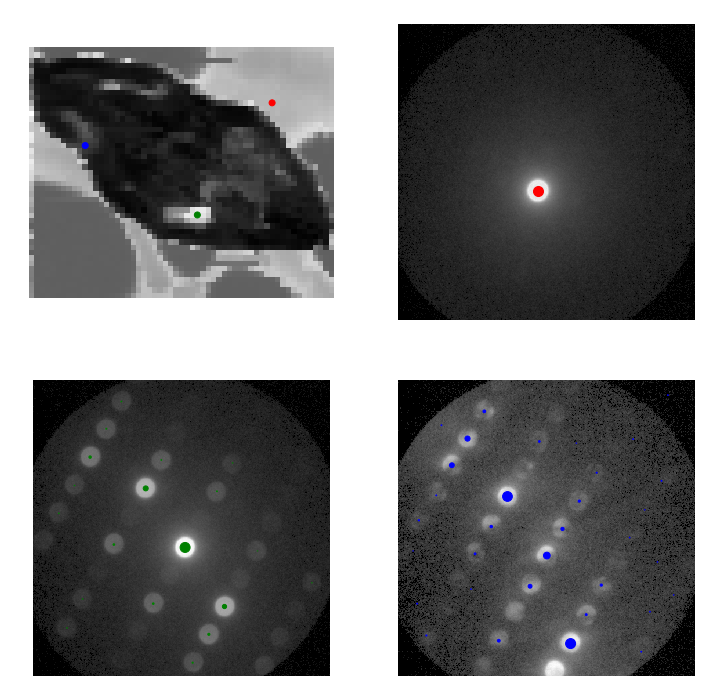

In [8]:
# Show results for a few DPs

xs=(10,31,18)
ys=(45,31,10)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = Braggpeaks.get_pointlist(xs[0],ys[0])
peaks1 = Braggpeaks.get_pointlist(xs[1],ys[1])
peaks2 = Braggpeaks.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Apply further thresholding

Optionally, we can copy the Bragg peak list just generated and then apply more stringent thresholds.

In [9]:
# Remove points based on new peak spacing or minimum relative intensity thresholds

maxNumPeaks = 60
minPeakSpacing = 50
minRelativeIntensity = 0.001

Braggpeaks_thresh = Braggpeaks.copy(name='Braggpeaks')  # Create a copy of the PointListArray to further threshold
Braggpeaks_thresh = threshold_Braggpeaks(Braggpeaks_thresh,
                                          minRelativeIntensity=minRelativeIntensity,
                                          minPeakSpacing=minPeakSpacing,
                                          maxNumPeaks=maxNumPeaks)

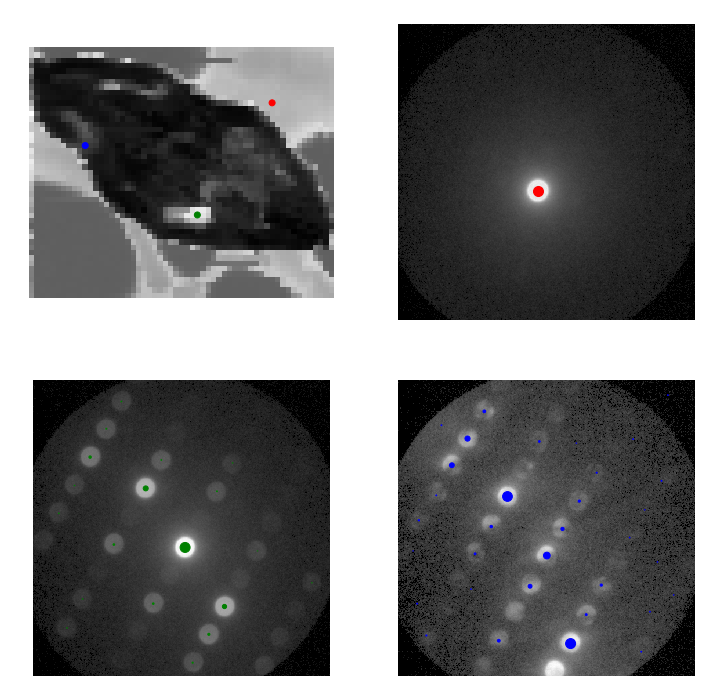

In [10]:
# Show newly thresholded results for a few DPs

xs=(10,31,18)
ys=(45,31,10)
power=0.3
size_scale_factor=100

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = Braggpeaks_thresh.get_pointlist(xs[0],ys[0])
peaks1 = Braggpeaks_thresh.get_pointlist(xs[1],ys[1])
peaks2 = Braggpeaks_thresh.get_pointlist(xs[2],ys[2])

if size_scale_factor == 0:
    ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r')
    ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g')
    ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b')
else:
    ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=size_scale_factor*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
    ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=size_scale_factor*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
    ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=size_scale_factor*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Save Bragg disk list

In [12]:
# Append to processing file

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append(Braggpeaks_thresh, fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
